<a href="https://colab.research.google.com/github/MichaelAnth/ML-for-Digital-Advertising-Applications/blob/master/Michael_Anthony_Python_Exercise1_Ad_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digital Advertising Python Exercise 1: Ad Analysis Assignment
## Michael Anthony 
### October 10th 2019

In this assignment, we import facebook ad campaign performance data and perform an exploratory analysis on the trends underlying this data set. We study how timing of the campaign influences the cost per impression, which factors are most corelated with ad performance, and build a multiple regression model to predict ad campaign outcomes.

In [0]:
#####################################################
# Document Setup
######################################################
# Load key packages
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # ensure all outputs are displayed from each cell
#######################################################
# Load Data
DATA_URL = 'http://128.138.93.164/aprd6342/data/TravelPonyFacebook.csv'
df = pd.read_csv(DATA_URL)
# view data frame
df.head()

,Start Date,End Date,Account,Campaign Name,Reach,Frequency,Impressions,Clicks,Unique Clicks,Amount Spent (USD),Page Likes,Page Engagement,Post Engagement,Post Likes,Post Comments,Post Shares,Photo Views,Website Clicks,Cost per Page Like (USD),Cost per Page Engagement (USD)
0,2013-12-02,2013-12-02,Bob Jackson,Cyber Weekend,278117,2.314303,643647,336,313,300.00,3,246,243,0,0,0,0,243,100.00,1.219512
1,2013-12-01,2013-12-01,Bob Jackson,Cyber Weekend,221255,2.079090,460009,376,348,300.00,6,215,209,0,0,0,0,209,50.00,1.395349
2,2013-11-30,2013-11-30,Bob Jackson,Cyber Weekend,267915,2.499069,669538,383,345,300.00,2,252,250,0,0,0,0,250,150.00,1.190476
3,2013-11-29,2013-11-29,Bob Jackson,Cyber Weekend,280332,2.365406,663099,301,275,300.00,3,257,254,0,0,0,0,254,100.00,1.167315
4,2013-11-22,2013-11-22,Bob Jackson,TravelPony: General Ads,14269,1.000420,14275,64,61,35.18,2,14,12,0,0,0,0,12,17.59,2.512857


# 1. How do Teporal Factors Influence CPM?

We now create a column for cost per impression - this allows us to develope a more accuratte basis for comprison between campaigns.
We also generate a column for the day of the week and the month that the campaign bagan. We plot CPM by weekday and month; this will allow us to see if there is a systematic difference in the cost per impression of advertisiments based on temporal factors.

In [0]:
df["CPM"]=df["Amount Spent (USD)"]/df["Impressions"]
df["CPM"]

0       0.000466
1       0.000652
2       0.000448
3       0.000452
4       0.002464
          ...   
3700    0.003512
3701    0.002936
3702    0.008919
3703    0.006643
3704    0.000439
Name: CPM, Length: 3705, dtype: float64

In [0]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['start_day_of_week'] = df['Start Date'].dt.day_name()
df['start_month'] = df['Start Date'].dt.month

df['End Date'] = pd.to_datetime(df['End Date'])
df['end_day_of_week'] = df['End Date'].dt.day_name()

df.head()
# import arrow
# dt = arrow.get(df['Start Date'], 'YYYY-MM-DD')
# dayoftheweek = dt.isoweekday()

,Start Date,End Date,Account,Campaign Name,Reach,Frequency,Impressions,Clicks,Unique Clicks,Amount Spent (USD),Page Likes,Page Engagement,Post Engagement,Post Likes,Post Comments,Post Shares,Photo Views,Website Clicks,Cost per Page Like (USD),Cost per Page Engagement (USD),CPM,start_day_of_week,start_month,end_day_of_week
0,2013-12-02,2013-12-02,Bob Jackson,Cyber Weekend,278117,2.314303,643647,336,313,300.00,3,246,243,0,0,0,0,243,100.00,1.219512,0.000466,Monday,12,Monday
1,2013-12-01,2013-12-01,Bob Jackson,Cyber Weekend,221255,2.079090,460009,376,348,300.00,6,215,209,0,0,0,0,209,50.00,1.395349,0.000652,Sunday,12,Sunday
2,2013-11-30,2013-11-30,Bob Jackson,Cyber Weekend,267915,2.499069,669538,383,345,300.00,2,252,250,0,0,0,0,250,150.00,1.190476,0.000448,Saturday,11,Saturday
3,2013-11-29,2013-11-29,Bob Jackson,Cyber Weekend,280332,2.365406,663099,301,275,300.00,3,257,254,0,0,0,0,254,100.00,1.167315,0.000452,Friday,11,Friday
4,2013-11-22,2013-11-22,Bob Jackson,TravelPony: General Ads,14269,1.000420,14275,64,61,35.18,2,14,12,0,0,0,0,12,17.59,2.512857,0.002464,Friday,11,Friday


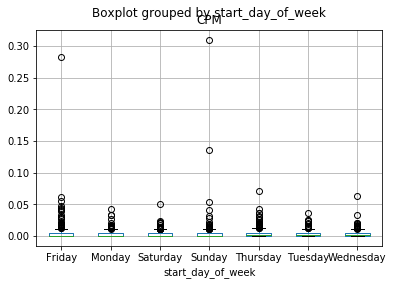

In [0]:
by_weekday=df.boxplot(column=["CPM"],by="start_day_of_week")
# import matplotlib.pyplot as plt
# by_weekday.title="Cost per ad view in USD by days of the week"
# by_weekday.show()

We notice that outliers (values above 0.05 CPM) are preventing us from discerning differences among the weekdays. We will cap the CPM at a zscore cutoff and create a new data frame with the data subset.

In [0]:
#df["CPM_no_outliers"]=df[[df["CPM"]>0.05,"CPM"]]
import numpy as np
from scipy import stats
# Remove rows where the CPM is more than 3 standard deviations away from the mean CPM for the data set
df_no_outliers=df[(np.abs(stats.zscore(df["CPM"])) < 3)] 
print(len(df))
print(len(df_no_outliers))

3705
3678


,CPM
start_day_of_week,
Friday,0.002806
Monday,0.002739
Saturday,0.002531
Sunday,0.002513
Thursday,0.003043
Tuesday,0.002969
Wednesday,0.002826



 minimum average CPM : 
                        CPM
start_day_of_week          
Sunday             0.002513

 maximum average CPM: 
                        CPM
start_day_of_week          
Thursday           0.003043


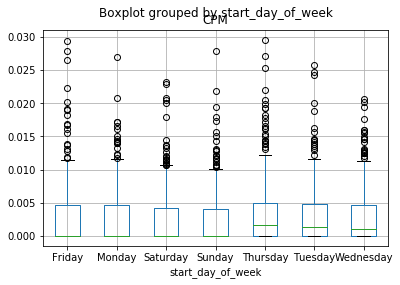

In [0]:
df_no_outliers.boxplot(column=["CPM"],by="start_day_of_week")
table = pd.pivot_table(df_no_outliers, values='CPM', index=['start_day_of_week'], aggfunc=np.average, fill_value=0)
table
print("\n minimum average CPM : ")
print(table[table.CPM == table.CPM.min()])
print("\n maximum average CPM: ")
print(table[table.CPM == table.CPM.max()]) 


#Based on the chart and table above, we can answer these two questions:
###When considering 'cost per impression', what day of the week works best? (What day is it cheapest to generate impressions)
* The cost per view is lowest on Sunday. This could indicate that ad competition and internet traffic volume is lowest on sunday so low ad bids can succed and the resulting cpm is lower.

###What day works worst? (What day is most expensive)
* Thursday has the highest average cpm in this data set.

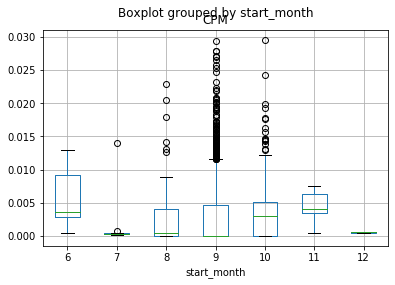

In [0]:
df_no_outliers.boxplot(column=["CPM"],by="start_month")

We see from this chart that the average CPM is highest in November followed by June. A t-test could be performed to determine if we can say with statistical certainty that november does in fact have a higher average CPM.

This plot also helps us diagnose limitations of this data set. It appears that the distribution in December and July is very tight, although this could be a generalizable trend, it seems suspiciously innconsistent with the data we have from the other months implying that there could have been a data collection issue during december and July that is biasing the results from those months. Additionallly, Months 1 through 5 do not have any data so we cannot say conculsively that November yields the highest CPM.

# Correlation Analysis: Spend and Cross Sectional Variables

In [0]:
df_no_outliers[["Amount Spent (USD)",'Reach','Frequency','Unique Clicks','Page Likes']].corr()

,Amount Spent (USD),Reach,Frequency,Unique Clicks,Page Likes
Amount Spent (USD),1.000000,0.703027,0.130077,0.882941,0.757470
Reach,0.703027,1.000000,0.334064,0.722161,0.304109
Frequency,0.130077,0.334064,1.000000,0.135002,0.000009
Unique Clicks,0.882941,0.722161,0.135002,1.000000,0.584415
Page Likes,0.757470,0.304109,0.000009,0.584415,1.000000


We see that the strongest correlation exists between Amount Spent and Unique Clicks (0.88). This implies that for each 100 dollars spent, we can predict 88 additional unique clicks on our ad.

# Multiple Regression
Predicting Unique Clicks when Reach and Frequency are the independent (predictor) variables.

In [0]:
import statsmodels.api as sm
X = df[['Frequency','Reach']]
y = df['Unique Clicks']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Unique Clicks   R-squared (uncentered):                   0.557
Model:                            OLS   Adj. R-squared (uncentered):              0.556
Method:                 Least Squares   F-statistic:                              2325.
Date:                Mon, 11 Nov 2019   Prob (F-statistic):                        0.00
Time:                        05:53:33   Log-Likelihood:                         -15973.
No. Observations:                3705   AIC:                                  3.195e+04
Df Residuals:                    3703   BIC:                                  3.196e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Frequency      3.6139      0.298     12.109      0.000       3.029       4.199
Reach          0.0019   3.12e-05     62.490      0.000       0.002       0.002
==============================================================================
Omnibus:                     5107.616   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5128392.747
Skew:                           7.331   Prob(JB):                         0.00
Kurtosis:                     184.674   Cond. No.                     9.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the multiple regression output we can see that both the Frequency and Reach variables are statistically significant (with a p value below 0.05) meaning they both explain unique varriance in the number of Unique Clicks on ads. Overall, this model only explains slightly over half the overall variation in Unique Clicks with a R squared value of 0.557. The reach coefficient is low, meaning that each additional person reached only represents a small increase in the likelyhood of a unique click. 

# Question Responses

###When considering 'cost per impression', what day of the week works best? (What day is it cheapest to generate impressions)
* The cost per view is lowest on Sunday. This could indicate that ad competition and internet traffic volume is lowest on sunday so low ad bids can succed and the resulting cpm is lower.

###What day works worst? (What day is most expensive)
* Thursday has the highest average cpm in this data set.

###Which correlation is the strongest? What does that mean practically? (respond in a tweet or less)
* We see that the strongest correlation exists between Amount Spent and Unique Clicks (0.88). This implies that for each 100 dollars spent, we can predict 88 additional unique clicks on our ad.

###What variable most strongly predicts unique clicks? What does that mean practically? (respond in a tweet or less)
* Both Frequency and Reach are statisitically significant predictors - they explain unique varriance in the number of unique clicks an ad recieves. The coefficient for frequency is higher meaning that for each jump in reach, we can precict an additional 3.6 unique clicks. With reach, an increase of 1000 people reached only produces 1.9 dditional unique clicks. 